In [1]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Reshape, MultiHeadAttention, Add, LayerNormalization, GlobalAveragePooling1D, Dense

2025-02-11 14:35:59.981721: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 14:35:59.997177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739264760.008424   83487 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739264760.011500   83487 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 14:36:00.023895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

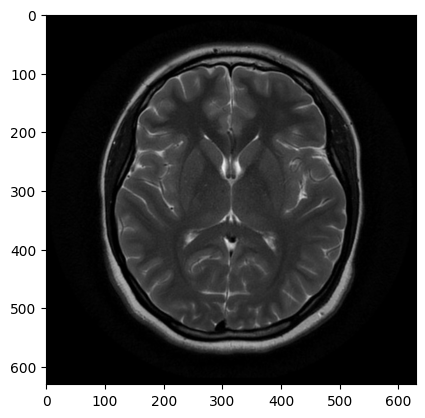

In [2]:
img=cv2.imread('brain_tumor_dataset/no/1 no.jpeg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
img.shape

(630, 630, 3)

In [4]:


datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# Training dataset
train_generator = datagen.flow_from_directory(
    directory="brain_tumor_dataset",
    target_size=(630, 630),
    batch_size=32,
    class_mode="sparse",  
    subset="training"
)


Found 248 images belonging to 2 classes.


In [5]:
img.shape

(630, 630, 3)

In [6]:

def vision_transformer(shape=(630, 630, 3)):
    inputs = Input(shape=shape)
    patch = 32  
    embed_dim = 128 

  
    patches = Conv2D(filters=embed_dim, kernel_size=patch, strides=patch)(inputs)
    patches = Reshape((-1, embed_dim))(patches)  

    transform = MultiHeadAttention(num_heads=8, key_dim=embed_dim)(patches, patches)
    transform = Add()([patches, transform])
    transform = LayerNormalization()(transform)


    pool = GlobalAveragePooling1D()(transform)
    dens1 = Dense(256, activation="relu")(pool)
    dens2 = Dense(64, activation="relu")(dens1)
    output=Dense(2)(dens2)
   

    model = keras.Model(inputs=inputs, outputs=output)
    return model


vit_model = vision_transformer()


2025-02-11 14:36:03.282100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
vit_model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

In [8]:
early=keras.callbacks.EarlyStopping(monitor="accuracy",patience=2)

In [9]:
vit_model.fit(train_generator,epochs=20,callbacks=[early])

/home/rijo/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4967 - loss: 0.8013
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5249 - loss: 0.7220
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6467 - loss: 0.6646
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5888 - loss: 0.6592
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6304 - loss: 0.6362
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5884 - loss: 0.7135
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5898 - loss: 0.6919


In [10]:
val_generator = datagen.flow_from_directory(
    directory="brain_tumor_dataset",
    target_size=(630, 630),
    batch_size=32,
    class_mode="sparse",
    subset="validation"
)


Found 62 images belonging to 2 classes.


In [11]:
img=cv2.imread('brain_tumor_dataset/no/1 no.jpeg')

In [12]:
img_resized = cv2.resize(img, (630, 630), interpolation=cv2.INTER_AREA)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

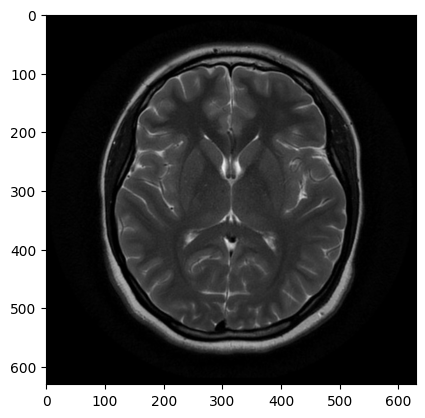

In [13]:
plt.imshow(img_resized)

In [14]:
img_resized.shape

(630, 630, 3)

In [15]:
img=np.expand_dims(img_resized,axis=0)/255

In [16]:
go=vit_model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [17]:
np.argmax(go)

0

In [25]:
loss,acc=vit_model.evaluate(val_generator)

/home/rijo/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6915 - loss: 0.6221


In [ ]:
import mlflow 
import dagshub
dagshub.init(repo_owner='slalrijo2005', repo_name='BTD', mlflow=True)



❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=0d55dec9-2448-4c4f-853d-3b07c1e37278&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=2c75823e2598a858a44a947d89ad5e939c70e1151df4356babd0d9a277dd940f




Accessing as slalrijo2005

Initialized MLflow to track repo "slalrijo2005/mlflow_test"

Repository slalrijo2005/mlflow_test initialized!

In [ ]:
mlflow.set_experiment("brain_tumor")
mlflow.set_registry_uri("https://dagshub.com/slalrijo2005/BTD.mlflow")

2025/02/11 14:49:17 INFO mlflow.tracking.fluent: Experiment with name 'brain_tumor' does not exist. Creating a new experiment.


In [27]:
with mlflow.start_run(run_name="brain_tumor_model"): 
      mlflow.log_params(vit_model.optimizer.get_config())
      mlflow.log_metrics({"accuracy": 0.6915})
      mlflow.tensorflow.log_model(vit_model,"tumor_model")

2025/02/11 14:56:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/02/11 14:56:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run brain_tumor_model at: https://dagshub.com/slalrijo2005/mlflow_test.mlflow/#/experiments/0/runs/da4ed25a394147efaed9780c05800406
🧪 View experiment at: https://dagshub.com/slalrijo2005/mlflow_test.mlflow/#/experiments/0


In [28]:
model_id="da4ed25a394147efaed9780c05800406"
model_name="tumor_model"
result = mlflow.register_model(
    f"runs:/{model_id}/{model_name}", "tumor_model"
)

Successfully registered model 'tumor_model'.
2025/02/11 15:00:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tumor_model, version 1
Created version '1' of model 'tumor_model'.
